# Notebook 02: Veri Görselleştirme ve Karşılaştırmalı Analiz

Bu notebook, enerji tüketim ve tahsilat verilerinin görselleştirilmesine odaklanmaktadır. 
**Notebook 01**'de temizlenen ve hazırlanan veriler kullanılarak aşağıdaki analizler yapılacaktır:

**Hedefler:**

İlçelere göre abone türü (Hesap Sınıfı) dağılımlarının karşılaştırılması.

Aylık ortalama tüketim trendlerinin incelenmesi.

Ödemelerin hangi şube ve ilçelerden yapıldığının analizi.

Zamanında ve geç ödeme oranlarının belirlenmesi.

Elektrik tüketiminin (kWh) histogram ve kutu grafikleri (Box Plot) ile incelenmesi.

---

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

if not os.path.exists('../outputs/figures'):
    os.makedirs('../outputs/figures')

# Uyarıları kapat
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

colors = ["#3182ce", "#38a169", "#ed8936", "#805ad5", "#e53e3e"]
sns.set_palette(sns.color_palette(colors))

## 1. Verinin Yüklenmesi
Notebook 01'de `processed_data` klasörüne kaydedilen dosyaların yüklenmesi.

In [4]:
df_tahakkuk = pd.read_pickle("../processed_data/tahakkuk_clean.pkl")
df_tahsilat = pd.read_pickle("../processed_data/tahsilat_clean.pkl")
df_tahsilat_1 = pd.read_pickle("../processed_data/tahsilat_1_clean.pkl")
    
print(f"Tahakkuk Kayıt Sayısı: {len(df_tahakkuk)}")
print(f"Tahsilat Kayıt Sayısı: {len(df_tahsilat)}")
print(f"Tahsilat 1 Kayıt Sayısı: {len(df_tahsilat_1)}")

Tahakkuk Kayıt Sayısı: 1185547
Tahsilat Kayıt Sayısı: 636993
Tahsilat 1 Kayıt Sayısı: 917632


## 2. Hesap Sınıfı Dağılımı (İlçe Karşılaştırması)
Her ilçedeki müşteri portföyünü anlamak için hesap sınıflarının dağılımına bakıyoruz.
Çok fazla hesap sınıfı olduğu için, her ilçedeki **en yaygın 5 hesap sınıfını** görselleştirilecektir.

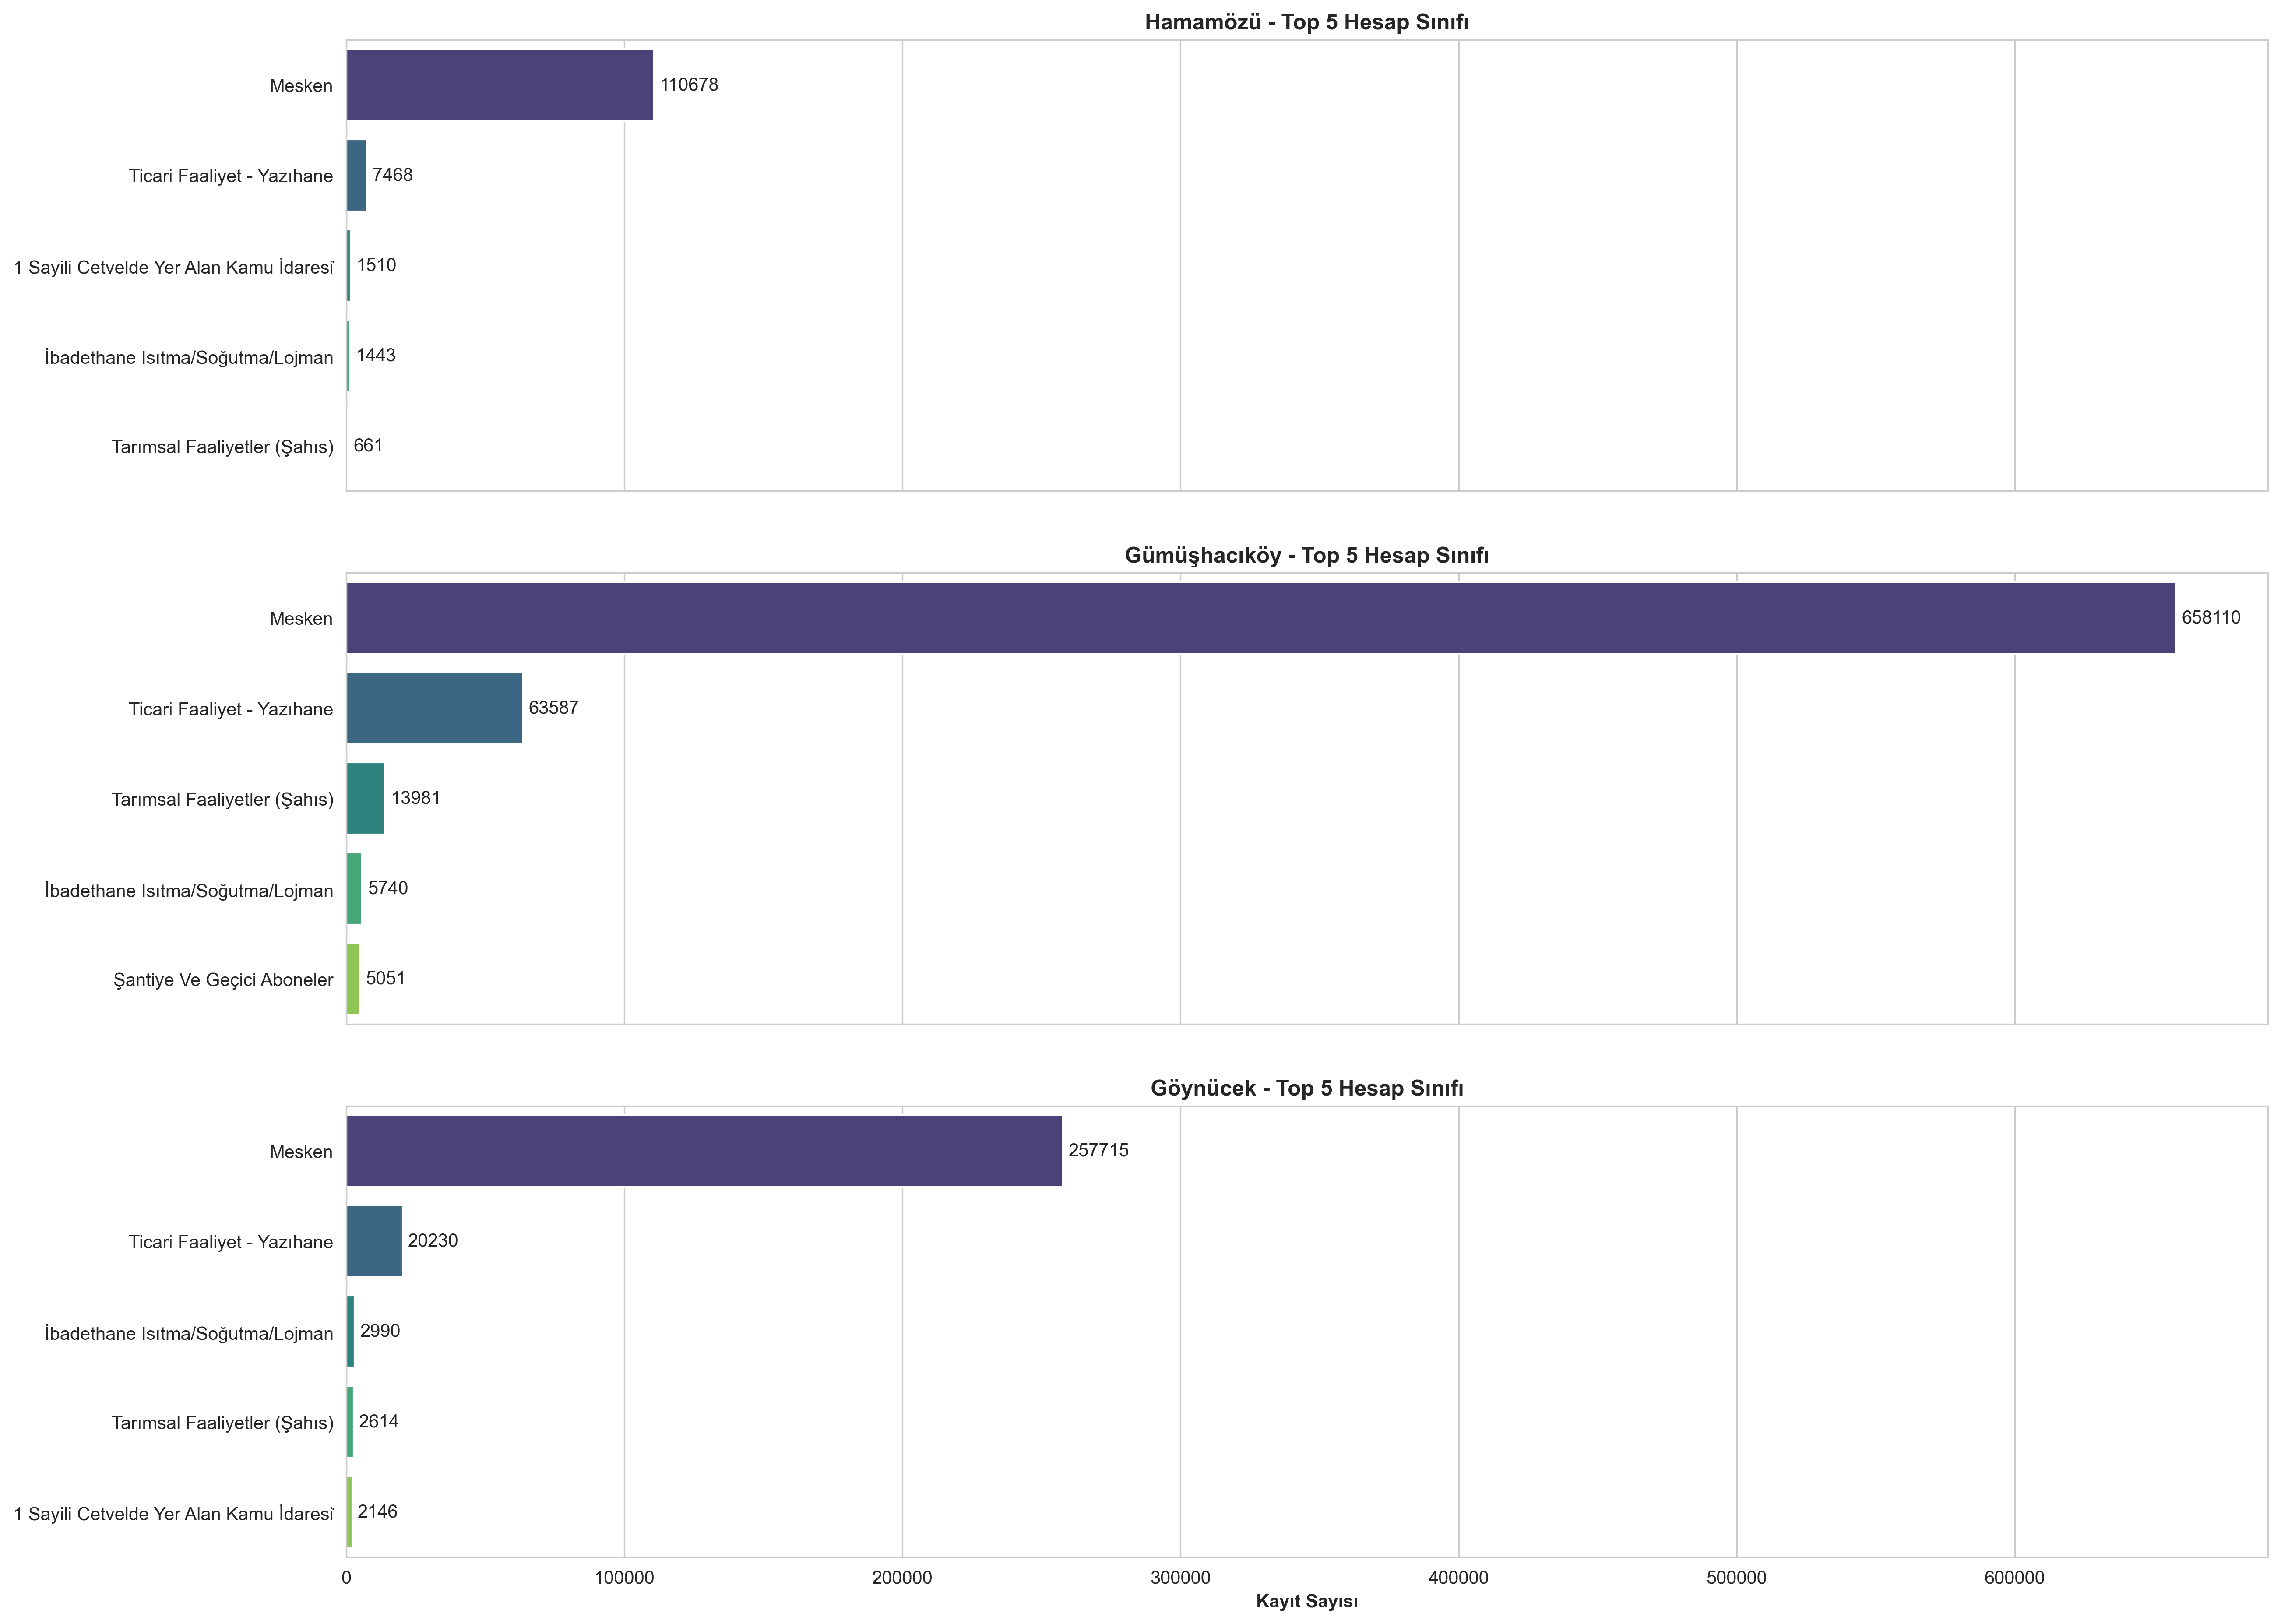

In [6]:
ilceler = df_tahakkuk['Ilce_Adi'].unique()

fig, axes = plt.subplots(3, 1, figsize=(18, 13), sharey=False, sharex=True, dpi=300)

for i, ilce in enumerate(ilceler):
    df_ilce = df_tahakkuk[df_tahakkuk['Ilce_Adi'] == ilce]
    
    top_classes = df_ilce['Hesap Sınıfı'].value_counts().head(5)
    
    top_classes.index = top_classes.index.str.title()
    
    sns.barplot(x=top_classes.values, y=top_classes.index, ax=axes[i], palette="viridis")
    
    for container in axes[i].containers:
        axes[i].bar_label(container, padding=3, fmt='%.0f')
    
    
    axes[i].set_title(f"{ilce} - Top 5 Hesap Sınıfı", fontsize=12, fontweight='bold')
    axes[i].set_xlabel("Kayıt Sayısı", fontweight = 'bold')
    axes[i].set_ylabel("")

plt.tight_layout(pad=3.0)
plt.savefig('../outputs/figures/ilce_karsilastirma.png', dpi=300)
plt.show()

## 3. Mevsimsel Tüketim Trendleri (Zaman Serisi)
Müşterilerin aylara göre ortalama elektrik tüketiminin (kWh) incelenerek mevsimsel etkilerin (yazın klima, kışın ısıtma vb.) analiz edilmesi.

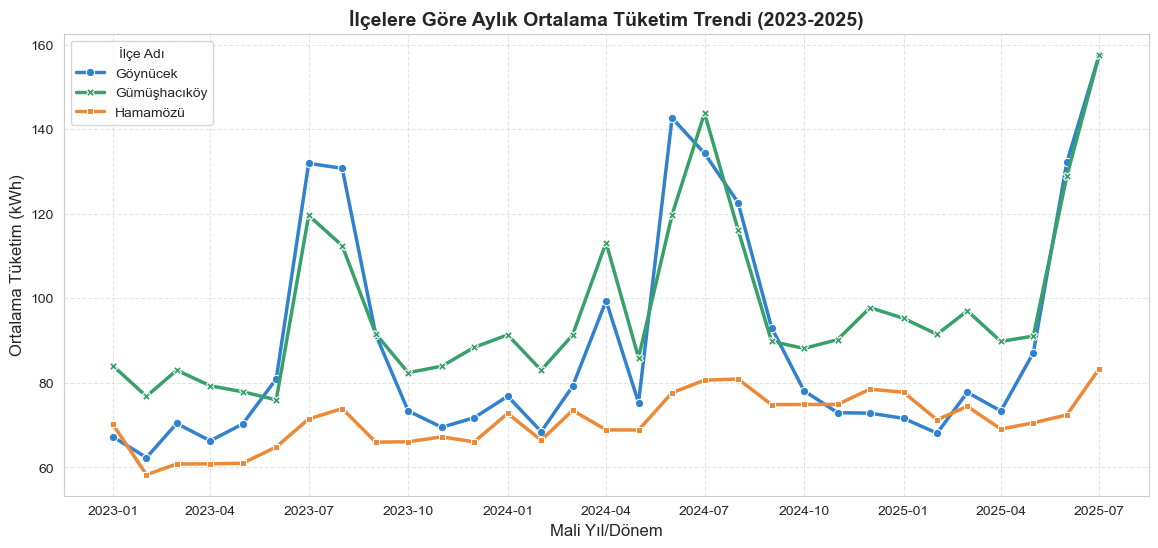

In [7]:
mevsimsel_data = df_tahakkuk.groupby(['Ilce_Adi', 'mali_yil_donem'])['kwh'].mean().reset_index()

plt.figure(figsize=(14, 6))

sns.lineplot(data=mevsimsel_data, x='mali_yil_donem', y='kwh', hue='Ilce_Adi', style='Ilce_Adi', markers=True, dashes=False, linewidth=2.5)

plt.title('İlçelere Göre Aylık Ortalama Tüketim Trendi (2023-2025)', fontsize=14, fontweight='bold')
plt.xlabel('Mali Yıl/Dönem', fontsize=12)
plt.ylabel('Ortalama Tüketim (kWh)', fontsize=12)
plt.legend(title='İlçe Adı')
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.savefig('../outputs/figures/mevsimsel_tuketim.png', dpi=300)
plt.show()

> Grafikte Temmuz-Ağustos aylarındaki zirve noktalar, tarımsal sulama dönemini veya yoğun klima kullanımını işaret ediyor olabilir. Hamamözü'nün diğer ilçelere göre daha stabil ve düşük bir profil çizdiği görülüyor. Bunun sebeplerinden biri `Hamamözü'ndeki tarımsal sulama faaliyetlerinin daha az olmasından` kaynaklanabilir. `Notebook 3` de bu hipotez test edilecektir.

## 4. Tahsilat Analizi
Ödemelerin hangi şubelerden ve hangi ilçelerden yapıldığının incelenmesi.

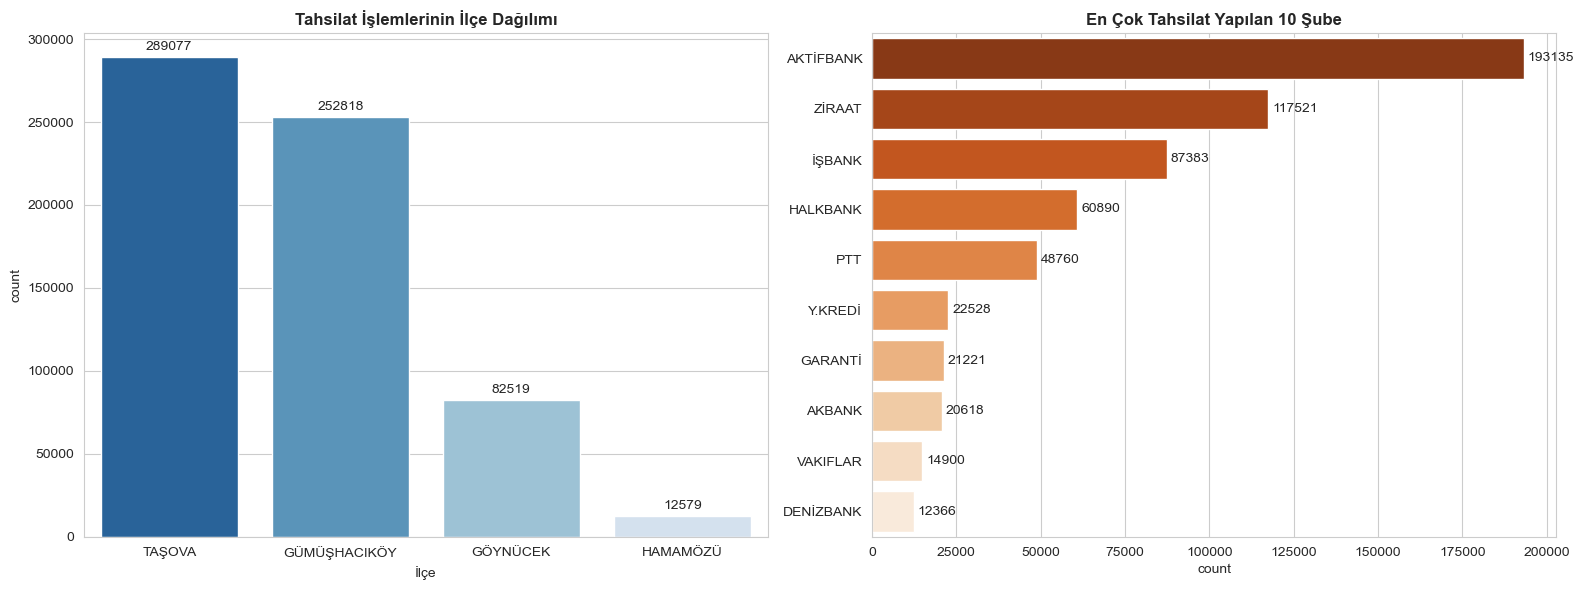

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

top_ilce = df_tahsilat['İlçe'].value_counts().index
sns.countplot(data=df_tahsilat, x='İlçe', ax=axes[0], order=top_ilce, palette='Blues_r')
axes[0].set_title('Tahsilat İşlemlerinin İlçe Dağılımı', fontweight='bold')
axes[0].tick_params(axis='x')
for c in axes[0].containers:
    axes[0].bar_label(c, padding =3, fmt='%.0f')

top_subeler = df_tahsilat['Şube'].value_counts().head(10).index
sns.countplot(data=df_tahsilat, y='Şube', ax=axes[1], order=top_subeler, palette='Oranges_r')
axes[1].set_title('En Çok Tahsilat Yapılan 10 Şube', fontweight='bold')
axes[1].set_ylabel("")
for c in axes[1].containers:
    axes[1].bar_label(c, padding =3, fmt='%.0f')

plt.tight_layout()
plt.savefig('../outputs/figures/ilce-sube_tahsilat_analizi.png', dpi=300)
plt.show()

> En çok tahsilat yapılan şube açık ara `AKTİFBANK` olmuştur. Ancak daha ilçe bazlı planlama ve yönetimi daha doğru analiz etmek için her ilçenin kendi içindeki tahsilat analizi yapılması gerekir.

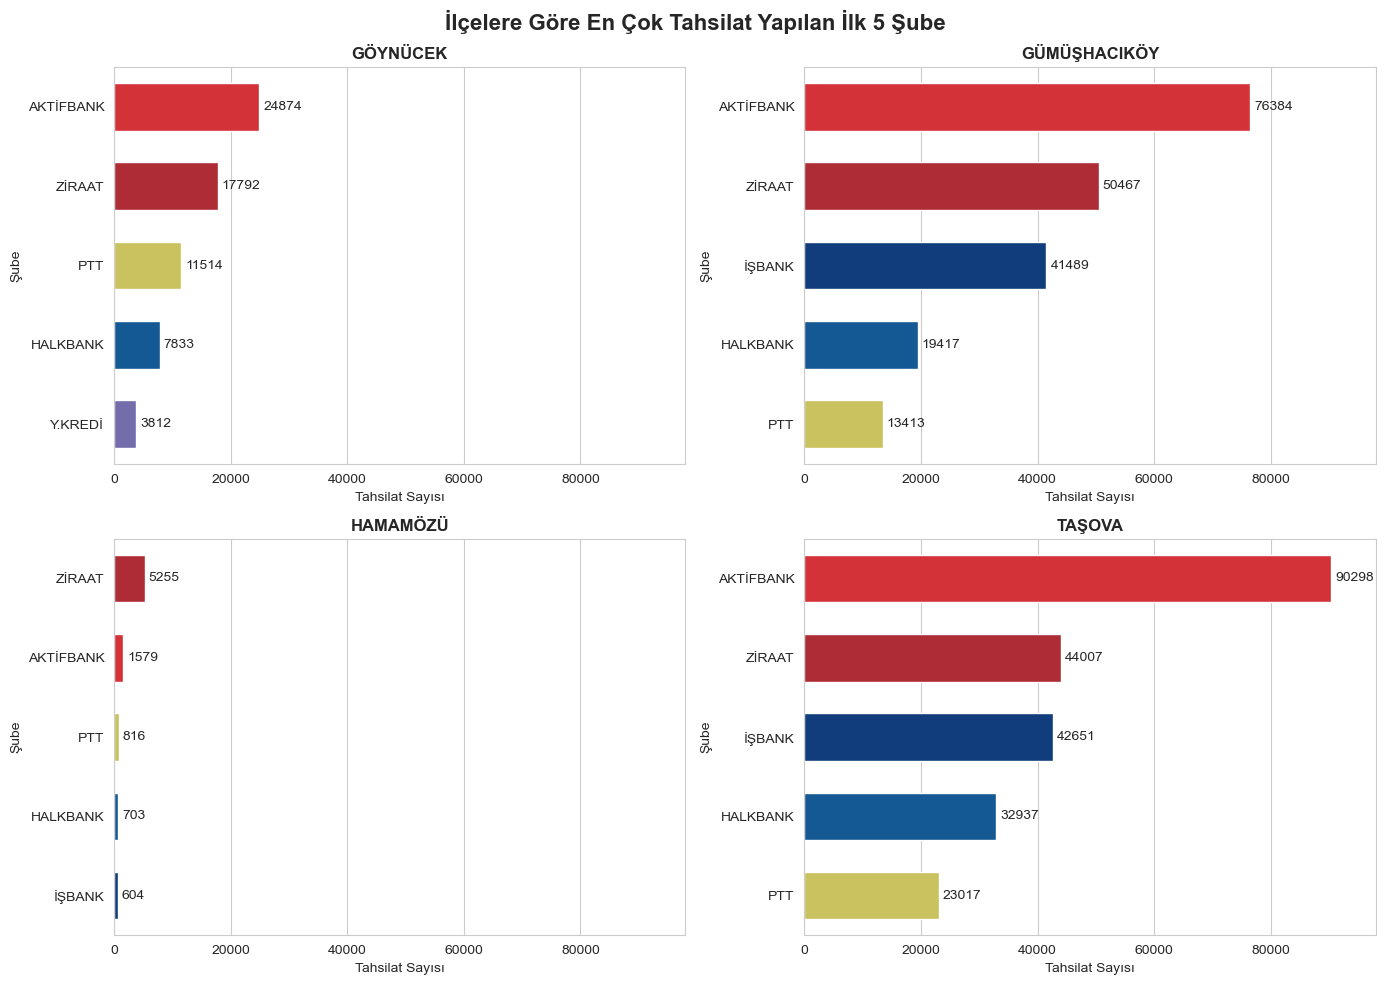

In [10]:
counts_tahsilat = ( df_tahsilat.groupby(['İlçe', 'Şube']).size().reset_index(name='Tahsilat_Sayısı'))

kurumsal_renkler = {
    'ZİRAAT': "#C21723",
    'İŞBANK': '#003A8F',
    'GARANTİ': '#00A651',
    'HALKBANK': '#005AA9',
    'VAKIFLAR': '#F9B000',
    'AKBANK': '#E60000',
    'AKTİFBANK': '#ee171f',
    'PTT': "#DBD14C",
    'DENİZBANK': '#88EAF5',
    'Y.KREDİ': '#6A63B6'
}

ilceler = counts_tahsilat['İlçe'].unique()[:4]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for ax, ilce in zip(axes, ilceler):
    
    ilce_data = (counts_tahsilat[counts_tahsilat['İlçe'] == ilce].sort_values('Tahsilat_Sayısı', ascending=False).head(5))
    
    sns.barplot(data=ilce_data, y='Şube',  x='Tahsilat_Sayısı', palette=kurumsal_renkler, ax=ax, width=0.6)
    
    ax.set_title(f'{ilce}', fontweight='bold')
    ax.set_xlabel('Tahsilat Sayısı')
    ax.set_ylabel('Şube')
    ax.set_xlim(0,98000)
    for c in ax.containers:
        ax.bar_label(c, padding =3, fmt='%.0f')

plt.suptitle('İlçelere Göre En Çok Tahsilat Yapılan İlk 5 Şube',fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('../outputs/figures/ilce_bazlı_tahsilat_analizi.png', dpi=300)
plt.show()


İlçeler karşılaştırıldığında, Taşova ilçesinin açık ara en yüksek tahsilat hacmine sahip olduğu, Hamamözü ilçesinde ise tahsilat işlemlerinin oldukça düşük seviyelerde kaldığı görülmektedir. Bu farklılık, yalnızca nüfus büyüklüğü ile değil; ilçelerdeki abone kompozisyonu ve hesap sınıflarının dağılımı ile de ilişkili olabilir.

Bu kapsamda, Notebook 3’te ilçe bazında mesken sayıları ile mesken dışı (ticari/sanayi vb) hesap sınıflarının hane sınıfına oranı incelenmiştir. Analiz sonuçları, Hamamözü ilçesinde hem abone sayısının hem de mesken dışı tüketimin toplam tüketim içindeki payının diğerlerine göre düşük olduğunu, buna karşın Gümüşhacıköy ilçelesinde hem abone sayısının hem de ticari ve sanayi abonelerinin mesken abonelerine oranla daha yüksek bir ağırlığa sahip olduğunu göstermektedir.

Bu durum, söz konusu ilçelerde hem tüketim hem de tahsilat hacminin daha yüksek olmasını açıklayan temel faktörlerden biri olarak değerlendirilebilir. Sonuç olarak tahsilat performansının yalnızca abone sayısı ile değil, abone türlerinin dağılımı ile birlikte değerlendirilmesi gerektiği ortaya çıkmaktadır.

## 5. Ödeme Performansı Analizi (Zamanında vs. Geç)
Müşterilerin ödeme kayıtlarında `Son Ödeme Tarihinden Önceki Tahsilat` veya `Son Ödeme Tarihindeki Tahsilat` sütunlarında veri varsa ödeme durumunun **"Zamanında"**, veri yoksa **"Geç"** olarak keydedilmesi.

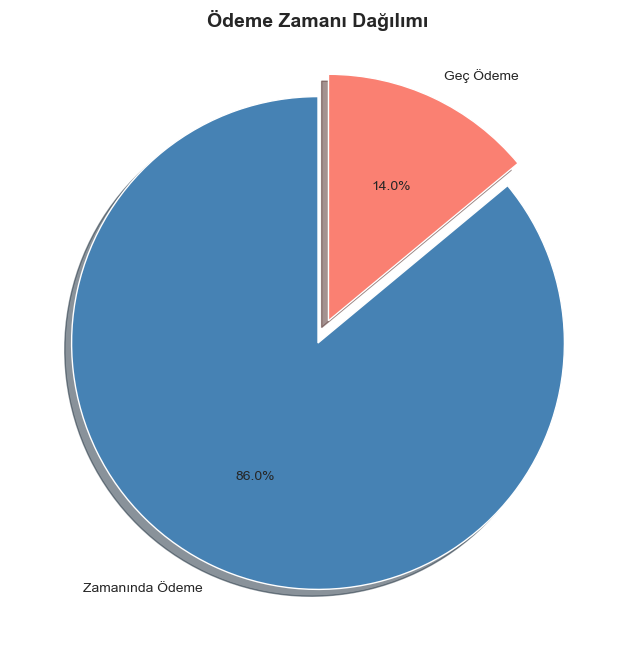

Odeme_Durumu
Zamanında Ödeme    789416
Geç Ödeme          128216
Name: count, dtype: int64

In [11]:
odeme_durumu = (df_tahsilat_1['Son Ödeme Tarihinden Önceki Tahsilat'].fillna(0) > 0) | \
                       (df_tahsilat_1['Son Ödeme Tarihindeki Tahsilat'].fillna(0) > 0)

df_tahsilat_1['Odeme_Durumu'] = np.where(odeme_durumu, 'Zamanında Ödeme', 'Geç Ödeme')

odeme_counts = df_tahsilat_1['Odeme_Durumu'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(odeme_counts, labels=odeme_counts.index, autopct='%1.1f%%',
        colors=["steelblue", "salmon"], startangle=90, explode=(0, 0.1), shadow=True)

plt.title('Ödeme Zamanı Dağılımı', fontsize=14, fontweight='bold')
plt.savefig('../outputs/figures/odeme_zamani_dagilimi.png', dpi=300)
plt.show()

display(odeme_counts)

## 6. Tüketim Dağılımı ve Outliers

Tüketim dağılımının histogram gösterimini daha mantıklı göstermek için 0-1000 kWh arasındaki verilere bakıldı. Çünkü çoğu abone az tüketirken, az sayıda sanayi vb. abone çok fazla tüketim yapar.

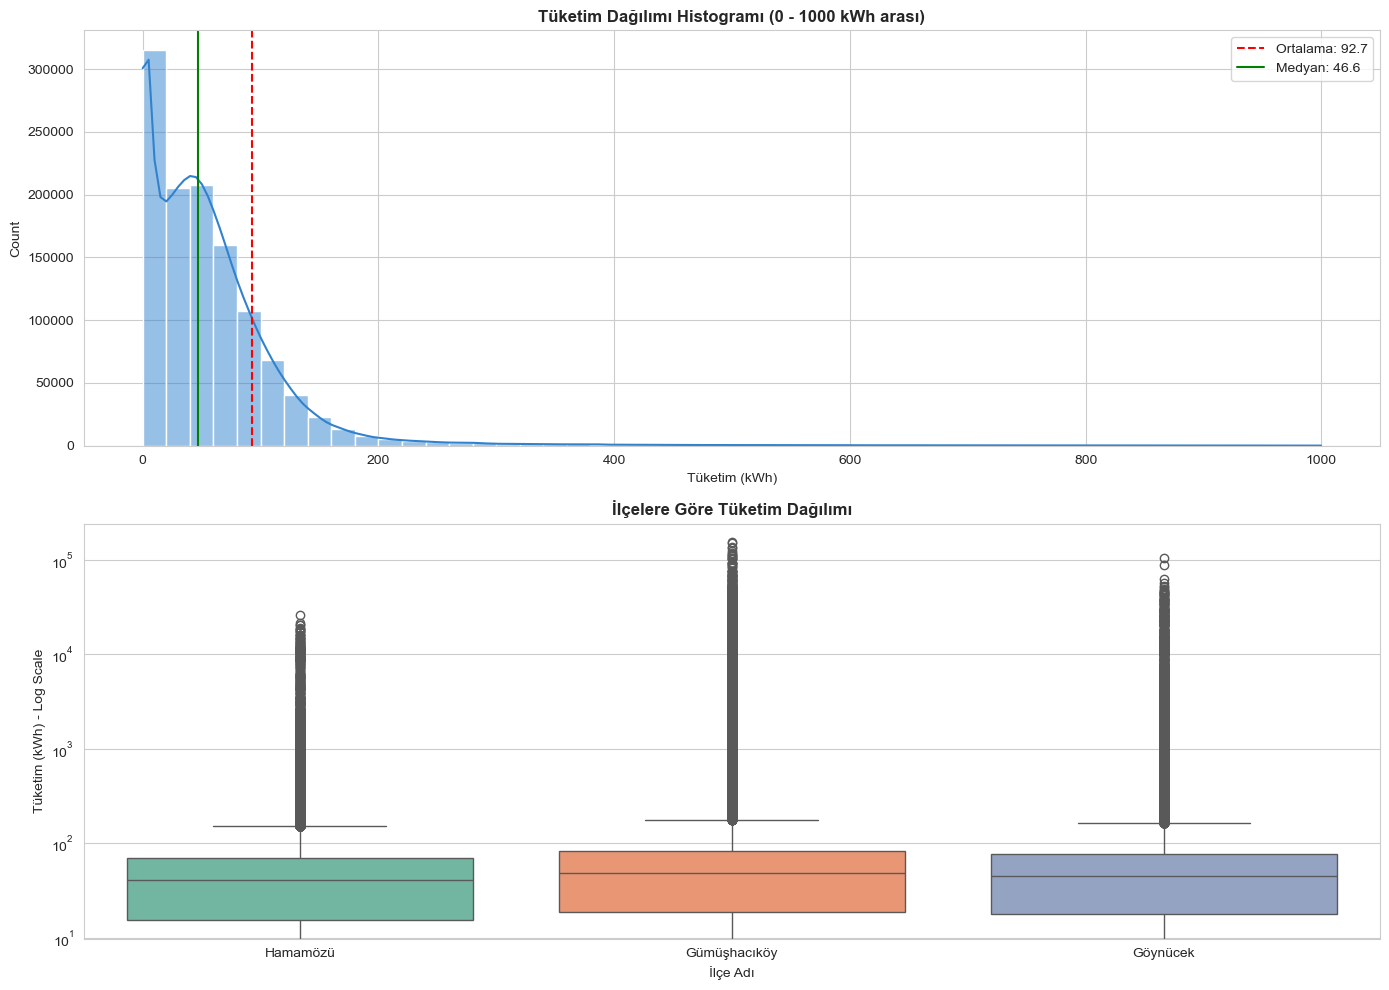

In [12]:
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

zoom_limit = 1000
data_zoomed = df_tahakkuk[df_tahakkuk['kwh'] <= zoom_limit]

sns.histplot(data=data_zoomed, x='kwh', bins=50, kde=True, ax=axes[0], color='#3182ce')
axes[0].set_title(f'Tüketim Dağılımı Histogramı (0 - {zoom_limit} kWh arası)', fontweight='bold')
axes[0].set_xlabel('Tüketim (kWh)')

axes[0].axvline(df_tahakkuk['kwh'].mean(), color='red', linestyle='--', label=f"Ortalama: {df_tahakkuk['kwh'].mean():.1f}")
axes[0].axvline(df_tahakkuk['kwh'].median(), color='green', linestyle='-', label=f"Medyan: {df_tahakkuk['kwh'].median():.1f}")
axes[0].legend()

sns.boxplot(data=df_tahakkuk, x='Ilce_Adi', y='kwh', ax=axes[1], palette="Set2")
axes[1].set_yscale('log') # Logaritmik eksen
axes[1].set_title('İlçelere Göre Tüketim Dağılımı', fontweight='bold')
axes[1].set_ylabel('Tüketim (kWh) - Log Scale')
axes[1].set_xlabel('İlçe Adı')

plt.tight_layout()
plt.savefig('../outputs/figures/tuketim_dagilimi_hist&boxplot.png', dpi=300)
plt.show()

In [13]:
print(f'Tüketim ortalaması: {df_tahakkuk['kwh'].mean():.1f}')
print(f'Tüketim medyan: {df_tahakkuk['kwh'].median():.1f}')

Tüketim ortalaması: 92.7
Tüketim medyan: 46.6


## Sonuç

Gçrselleştirmeler sonucunda:

    1.  Hesap Sınıfı Dağılımı ve Tüketim Dağılımı görselleştirmeleri sonucunda her üç ilçede de "Mesken" abonelerinin çoğunlukta olduğu, ancak Gümüşhacıköy'de ticari/tarımsal çeşitliliğin daha fazla olabileceği görüldü.

    2.  Yaz aylarında mevsimsellik etkisinden dolayı (özellikle Temmuz) belirgin bir tüketim artışı görüldü.

    3.  Hamamözü ilçesindeki toplam elektrik tüketiminin düşük olmasının sebebi, hem genel kayıtlı abone sayısının hem de ticari vb. abone sayısının diğer ilçelere göre çok aşağı seviyede olmaıyla ilişkili olabilir.

    4.  Müşterilerin büyük çoğunluğunun (%86 civarı) ödemelerini zamanında yaptığı tespit edildi.

    5.  Tüketim verisi sağa çarpık. Medyan (yaklaşık 46 kWh), ortalamadan (yaklaşık 92 kWh) oldukça düşük. Bu durum, az sayıda çok yüksek tüketen abonelerin ortalamayı yukarı çektiğini ve grafikteki verileri kanıtlıyor.

MEHMET ENES TEMEL

mehmetenestemel@gmail.com